### Advanced Fixed Income and Credit

Case Study: Deutsche Bank - Finding Relative Value Trades

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from scipy.interpolate import LSQUnivariateSpline
from matplotlib.ticker import PercentFormatter
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore")

**Q1** Bootstrapping Zero-Coupon Yields from Coupon
Bond Prices

In [2]:
file_path = 'data.xls'  
exhibit_1 = pd.read_excel(file_path, sheet_name='Exhibit 1', header=2, usecols=["Coupon Rate (%)", "Maturity Date", "Current Price"])[:]
exhibit_1

,Coupon Rate (%),Maturity Date,Current Price
0,3.000,2/15/2004,101.0544
1,2.125,8/15/2004,100.9254
2,1.500,2/15/2005,99.8942
3,6.500,8/15/2005,109.0934
4,5.625,2/15/2006,108.4380
5,2.375,8/15/2006,99.7848
6,6.250,2/15/2007,111.7184
7,3.250,8/15/2007,101.0841
8,3.000,2/15/2008,99.1692
9,3.250,8/15/2008,99.2710


In [3]:
exhibit_4 = pd.read_excel(file_path, sheet_name='Exhibit 4', header=2)[:-4] 
exhibit_4.head()

,Maturity (years),Model Prediction (BEY)
0,1y,1.2443%
1,2y,1.8727%
2,3y,2.4110%
3,4y,2.9665%
4,5y,3.4454%


In [4]:
reference_date = datetime(2003, 8, 15)
exhibit_1['Maturity Date'] = pd.to_datetime(exhibit_1['Maturity Date'], format='%m/%d/%Y')

T = np.round((exhibit_1['Maturity Date'] - reference_date).dt.days / 365, 1).values #to account for leap year

current_prices = exhibit_1['Current Price'].values
coupons = exhibit_1['Coupon Rate (%)'].values
periods = 2*T

In [5]:
# Extract zero-coupon yields and maturities, removing "%" and "y" characters
zc_model = (exhibit_4['Model Prediction (BEY)'].str.rstrip('%').astype(float)/100).values
mat_model = exhibit_4['Maturity (years)'].str.rstrip('y').astype(float).values

In [6]:
exhibit_1.tail()

,Coupon Rate (%),Maturity Date,Current Price
47,6.375,2027-08-15,111.4036
48,6.125,2028-02-15,108.0391
49,5.500,2028-08-15,99.6330
50,5.250,2029-02-15,96.2876
51,6.125,2029-08-15,108.4062


In [7]:
# calculate the prices of discount bonds and the associeted yeld 
# First discoutn 
discount_factors = np.zeros(len(exhibit_1))
zc = np.zeros(len(exhibit_1))
discount_factors[0] = exhibit_1.iloc[0, 2] / (100 + exhibit_1.iloc[0, 0]/2)

# First yeld  
exp = (2 * T[0])**-1
zc[0] = 2*(((1/discount_factors[0])**(exp)) - 1)

for i in range(1, len(exhibit_1)):
    CFs = np.full(i + 1, exhibit_1.iloc[i, 0]/2)
    CFs[-1] = 100 + exhibit_1.iloc[i, 0]/2
    discount_factors[i] = (exhibit_1.iloc[i, 2] - np.dot(CFs[:i], discount_factors[:i])) / CFs[-1]
    exp = (2 * T[i])**-1
    zc[i] = 2*(((1/discount_factors[i])**(exp)) - 1)
    
discount_factors, zc

(array([0.99560985, 0.98817627, 0.97673807, 0.96340626, 0.94737455,
        0.92896974, 0.90756404, 0.88741808, 0.86479128, 0.84155889,
        0.81937986, 0.79400038, 0.76934326, 0.74650741, 0.72406151,
        0.7012044 , 0.68007172, 0.66038132, 0.64338905, 0.62775437,
        0.6117382 , 0.58534032, 0.54618527, 0.52867849, 0.50984615,
        0.49271149, 0.47604957, 0.45755133, 0.44431472, 0.42935291,
        0.41285297, 0.39874372, 0.38618007, 0.37199905, 0.36048081,
        0.34928736, 0.33805336, 0.32785897, 0.31779099, 0.3094697 ,
        0.3012222 , 0.2902055 , 0.28045321, 0.27259259, 0.26759827,
        0.25775556, 0.25127702, 0.24424579, 0.23743866, 0.23298608,
        0.22823828, 0.22023981]),
 array([0.00881901, 0.01192962, 0.01575289, 0.01872718, 0.02174163,
        0.02471112, 0.02790463, 0.03008378, 0.03254351, 0.03479914,
        0.0365495 , 0.03881711, 0.04075084, 0.04220336, 0.0435172 ,
        0.0448653 , 0.04587793, 0.04663971, 0.04696459, 0.04710684,
        0.0473

In [8]:
# Create a DataFrame with Maturity, Zero-Coupon Yield (ZC), and Discount Factor (DF)
bootstrap_df = pd.DataFrame({
    "Maturity (Years)": T,
    "Zero-Coupon Yield (ZC)": zc,
    "Discount Factor (DF)": discount_factors
})

bootstrap_df.head()

,Maturity (Years),Zero-Coupon Yield (ZC),Discount Factor (DF)
0,0.5,0.008819,0.995610
1,1.0,0.011930,0.988176
2,1.5,0.015753,0.976738
3,2.0,0.018727,0.963406
4,2.5,0.021742,0.947375


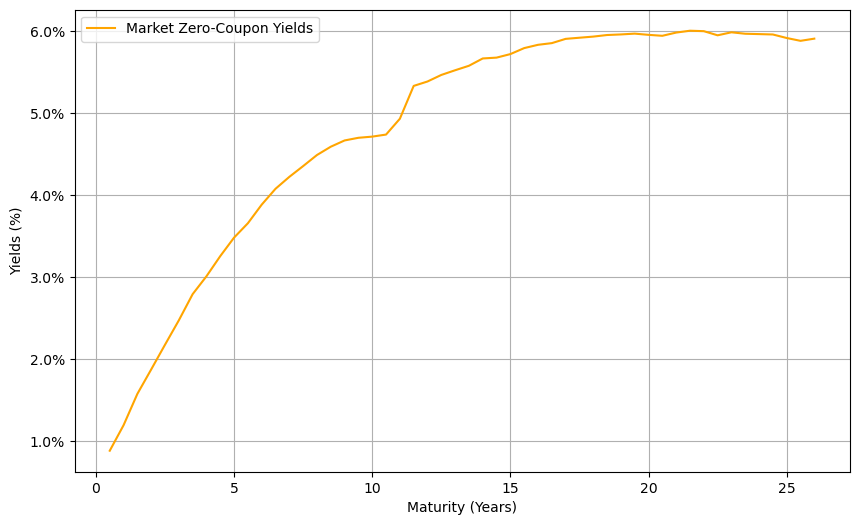

In [9]:
# Plot the Zero-Coupon Yield Curve from bootstrapping alongside the model data
plt.figure(figsize=(10, 6))
plt.plot(bootstrap_df["Maturity (Years)"], zc, linestyle='-', color='orange', label="Market Zero-Coupon Yields")

# Labeling the plot
plt.xlabel("Maturity (Years)")
plt.ylabel("Yields (%)")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # Adjust formatter for percentage values directly
# plt.title("Market vs. Model Zero-Coupon Yields Derived from Discount Bond Prices")
plt.legend()
plt.grid()
plt.show()

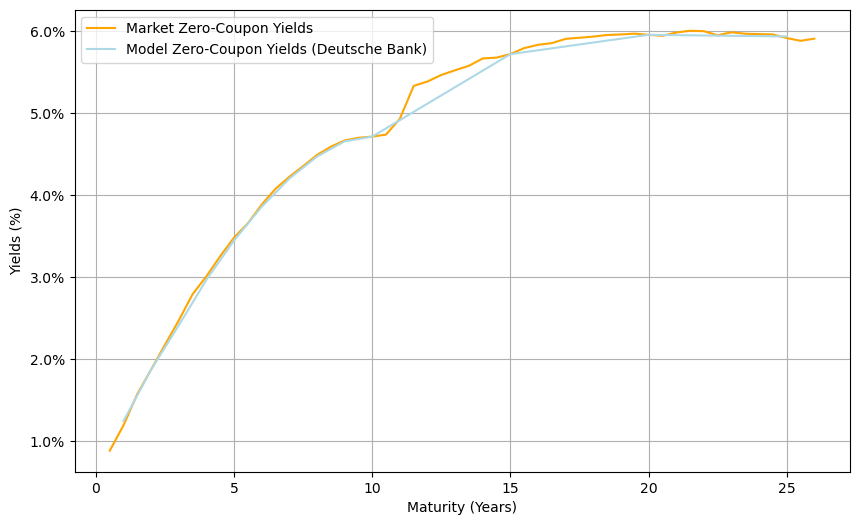

In [10]:
# Plot the Zero-Coupon Yield Curve from bootstrapping alongside the model data
plt.figure(figsize=(10, 6))
plt.plot(bootstrap_df["Maturity (Years)"], bootstrap_df["Zero-Coupon Yield (ZC)"], linestyle='-', color='orange', label="Market Zero-Coupon Yields")
plt.plot(mat_model, np.array(zc_model), linestyle='-', color='lightblue', label="Model Zero-Coupon Yields (Deutsche Bank)")

# Labeling the plot
plt.xlabel("Maturity (Years)")
plt.ylabel("Yields (%)")
# plt.title("Zero-Coupon Yield Curve")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # Adjust formatter for percentage values directly
plt.legend()
plt.grid()
plt.show()

In [11]:
mat_model

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 15., 20., 25.])

In [12]:
zc_index = [np.where(T == i)[0][0] for i in mat_model]
zc_market = [zc[i] for i in zc_index]

threshold = 0.0001

actions = [
    "sell" if (zc_model[i] - zc_market[i]) >  threshold
    else "buy" if (zc_market[i] - zc_model[i]) > threshold
    else "hold"
    for i in range(len(zc_market))
]

df_results = pd.DataFrame({
    "Maturity (Years)": mat_model,
    "Model ZC Yields": zc_model,
    "Selected ZC Yields": zc_market,
    "move": 100*(zc_market - zc_model),
    "Action": actions
})

df_results

,Maturity (Years),Model ZC Yields,Selected ZC Yields,move,Action
0,1.0,0.012443,0.011930,-0.051338,sell
1,2.0,0.018727,0.018727,0.000018,hold
2,3.0,0.024110,0.024711,0.060112,buy
3,4.0,0.029665,0.030084,0.041878,buy
4,5.0,0.034454,0.034799,0.034514,buy
5,6.0,0.038557,0.038817,0.026011,buy
6,7.0,0.041996,0.042203,0.020736,buy
7,8.0,0.044677,0.044865,0.018830,buy
8,9.0,0.046528,0.046640,0.011171,buy
9,10.0,0.047107,0.047107,-0.000016,hold


**Q2** Cubic Spline

In [13]:
from scipy.interpolate import CubicSpline

def create_cubic_spline(T, zc, knots):
    # Find indices for each knot year in T
    knot_indices = [np.where(T == t)[0][0] for t in knots]
    zc_knots = [zc[i] for i in knot_indices]
    
    # Create and return the cubic spline evaluated on T
    cubic_spline = CubicSpline(knots, zc_knots, bc_type='natural')
    spline_yields = cubic_spline(T)
    return cubic_spline, spline_yields

In [14]:
from scipy.interpolate import LSQUnivariateSpline

# Give knots more weight over the fitting 
def create_weight_vector(T, knots, base_weight=0.1, knot_weight=10):
    weights = np.full(len(T), base_weight)
    for knot in knots:
        knot_index = int((np.abs(T - knot)).argmin())
        weights[knot_index] = knot_weight
    return weights


def create_smooth_spline(T, zc, knots):
    
    w_vect = create_weight_vector(T, knots)
    smoothing_spline = LSQUnivariateSpline(T, zc,  knots, k=3, w = w_vect)
    smoothing_yields = smoothing_spline(T)
    return smoothing_spline, smoothing_yields


In [15]:
knots_5 = [2, 5, 10, 15, 20]
knots_2 = [5, 20]

cubic_spline_5, spline_yields_5 = create_cubic_spline(T, zc, knots_5)
cubic_spline_2, spline_yields_2 = create_cubic_spline(T, zc, knots_2)

smoothing_spline_5 , smoothed_yields_5 = create_smooth_spline(T, zc, knots_5)
smoothing_spline_2, smoothed_yields_2 = create_smooth_spline(T, zc, knots_2)


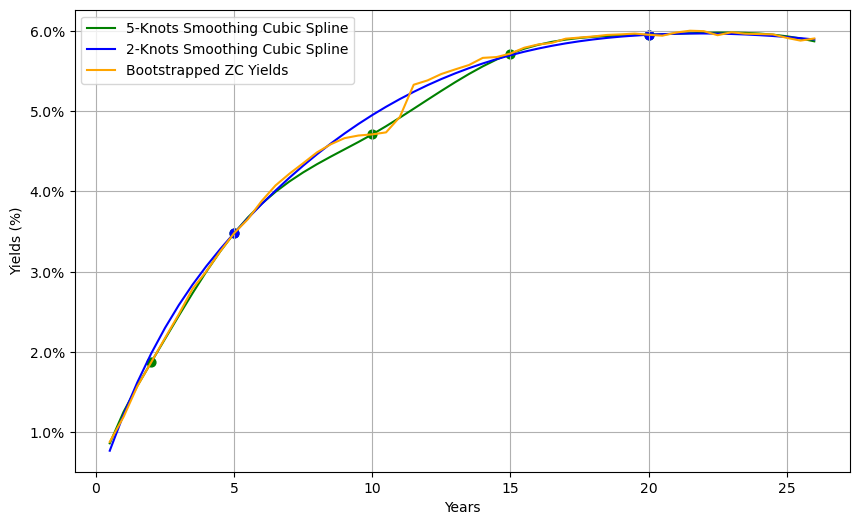

In [16]:
plt.figure(figsize=(10, 6))

plt.plot(T, smoothed_yields_5, color='green', label='5-Knots Smoothing Cubic Spline')
plt.scatter(knots_5, smoothing_spline_5(knots_5), s=40, color='green')

plt.plot(T, smoothed_yields_2, color='blue', label='2-Knots Smoothing Cubic Spline')
plt.scatter(knots_2, smoothing_spline_2(knots_2), s=40, color='blue')

plt.plot(T, zc, label='Bootstrapped ZC Yields', color='orange')

# plt.title('Smoothed Cubic Spline Interpolation of ZC Yields')
plt.xlabel('Years')
plt.ylabel('Yields (%)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # Adjust formatter for percentage values directly
plt.legend()
plt.grid()
plt.show()

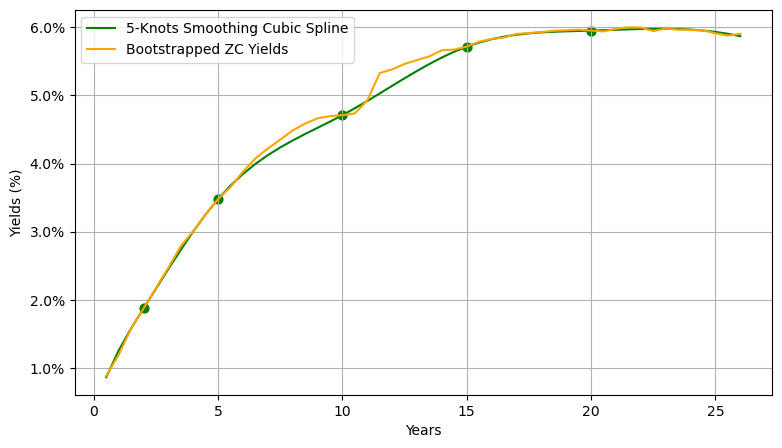

In [17]:
plt.figure(figsize=(9, 5))

plt.plot(T, smoothed_yields_5, color='green', label='5-Knots Smoothing Cubic Spline')
plt.scatter(knots_5, smoothing_spline_5(knots_5), s=40, color='green')

plt.plot(T, zc, label='Bootstrapped ZC Yields', color='orange')

# plt.title('Smoothed Cubic Spline Interpolation of ZC Yields')
plt.xlabel('Years')
plt.ylabel('Yields (%)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.grid()
plt.show()

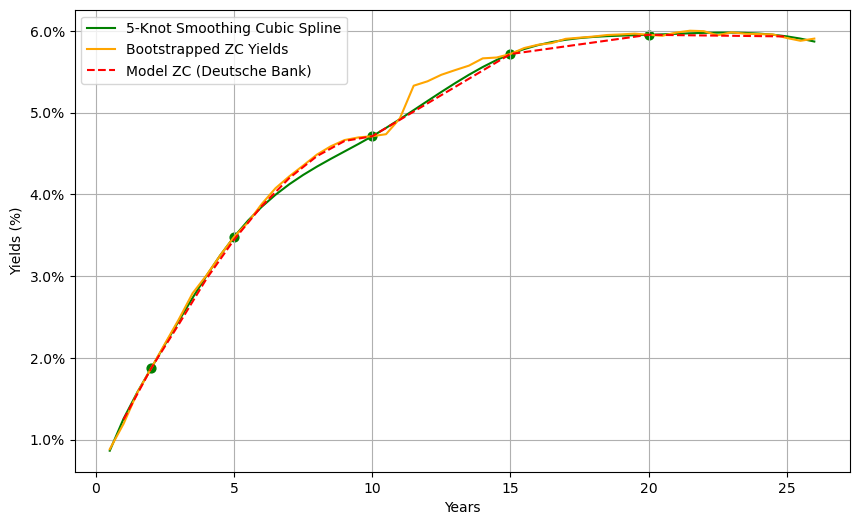

In [18]:
plt.figure(figsize=(10, 6))

plt.plot(T, smoothed_yields_5, color='green', label='5-Knot Smoothing Cubic Spline')
plt.scatter(knots_5, smoothing_spline_5(knots_5), s=40, color='green')

plt.plot(T, zc, label='Bootstrapped ZC Yields', color='orange')

plt.plot(mat_model, np.array(zc_model), marker='', linestyle='--', color='red', label="Model ZC (Deutsche Bank)")

# plt.title('Smoothed Cubic Spline Interpolation of ZC Yields')
plt.xlabel('Years')
plt.ylabel('Yields (%)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend() 
plt.grid()
plt.show()

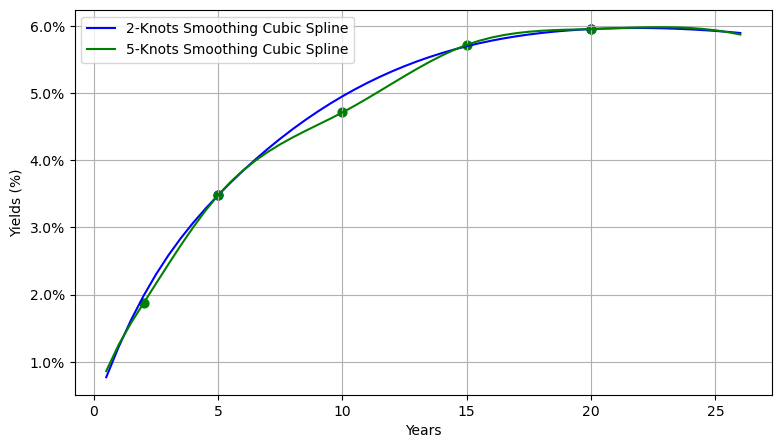

In [19]:
plt.figure(figsize=(9, 5))

plt.plot(T, smoothed_yields_2, color='blue', label='2-Knots Smoothing Cubic Spline')
plt.scatter(knots_2, smoothing_spline_2(knots_2), s=40, color='blue')

plt.plot(T, smoothed_yields_5, color='green', label='5-Knots Smoothing Cubic Spline')
plt.scatter(knots_5, smoothing_spline_5(knots_5), s=40, color='green')

# plt.title('Smoothed Cubic Spline Interpolation of ZC Yields')
plt.xlabel('Years')
plt.ylabel('Yields (%)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.grid()
plt.show()

In [20]:
mse_spline_2 = np.mean((zc - smoothed_yields_2) ** 2)
mse_spline_5 = np.mean((zc - smoothed_yields_5) ** 2)

print(f"MSE 2 knots: {mse_spline_2:.2g}")
print(f"MSE 5 knots: {mse_spline_5:.2g}")

MSE 2 knots: 6.8e-07
MSE 5 knots: 7e-07


In [21]:
mse_cubic_2 = np.mean((zc - spline_yields_2) ** 2)
mse_cubic_5 = np.mean((zc - spline_yields_5) ** 2)

print(f"MSE 2 knots: {mse_cubic_2:.2g}")
print(f"MSE 5 knots: {mse_cubic_5:.2g}")

MSE 2 knots: 4.4e-05
MSE 5 knots: 1.6e-06


**Q3** Nelson-Siegel Model

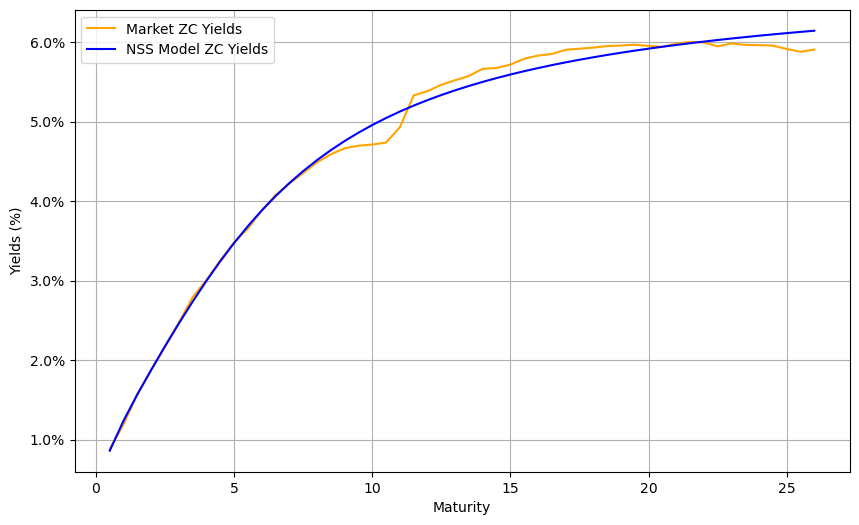

In [22]:

# NSS yield curve model
def nss_curve(T, b0, b1, b2, b3,t1, t2):
    a1 = (1 - np.exp(-T / t1)) / (T /t1)
    a2 = a1 - np.exp(-T /t1)
    a3 = (1 - np.exp(-T / t2)) / (T / t2) - np.exp(-T / t2)
    return b0 + b1 * a1 + b2 * a2 + b3 * a3

# Error function (squared residuals)
def nss_error(params, T, yields):
    return np.sum((nss_curve(T, *params) - yields) ** 2)

# Optimiser for NSS model
def fit_nss(b0, b1, b2, b3,t1, t2, T, yields):
    res = minimize(nss_error, x0=[b0, b1, b2, b3,t1, t2], args=(T, yields))
    return res.x if res.success else []

# Initial parameter guesses
b0, b1, b2, b3,t1, t2 = 0.1, 0.1, -1, -1, 1, 1

# Optimise NSS parameters
opt_params = fit_nss(b0, b1, b2, b3,t1, t2, T, zc)

# Calculate NSS yields with optimized parameters
nss_yields = nss_curve(T, *opt_params)

# Load optimised parameters for each factor
b0, b1, b2, b3, t1, t2 = opt_params

# Plot NSS model vs market data
plt.figure(figsize=(10, 6))
plt.plot(T, np.array(zc), label='Market ZC Yields', color='orange')
plt.plot(T, np.array(nss_yields), label='NSS Model ZC Yields', color='blue')
plt.xlabel('Maturity')
plt.ylabel('Yields (%)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.title('Market Yields vs. NSS Model')
plt.legend()
plt.grid()
plt.show()

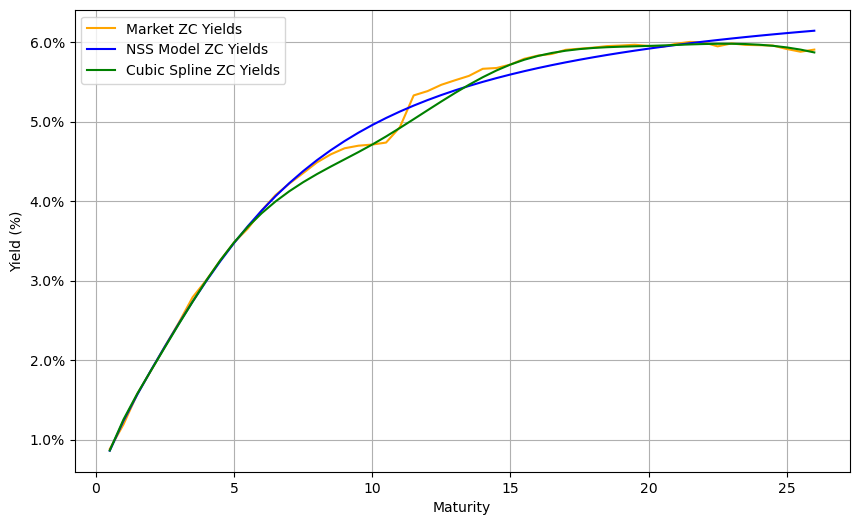

In [23]:
# Plot NSS model vs market data
plt.figure(figsize=(10, 6))
plt.plot(T, np.array(zc), label='Market ZC Yields', color='orange')
plt.plot(T, np.array(nss_yields), label='NSS Model ZC Yields', color='blue')
plt.plot(T, np.array(smoothed_yields_5), label='Cubic Spline ZC Yields', color='green')
plt.xlabel('Maturity')
plt.ylabel('Yield (%)')
#plt.title('NSS Model vs Cubic Spline')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.grid()
plt.show()

In [24]:
mse_nss = np.mean((zc - nss_yields) ** 2)
mse_spline = np.mean((zc - smoothed_yields_5) ** 2)

print(f"MSE nss: {mse_nss:.2g}")
print(f"MSE spline: {mse_spline:.2g}")

MSE nss: 1.4e-06
MSE spline: 7e-07


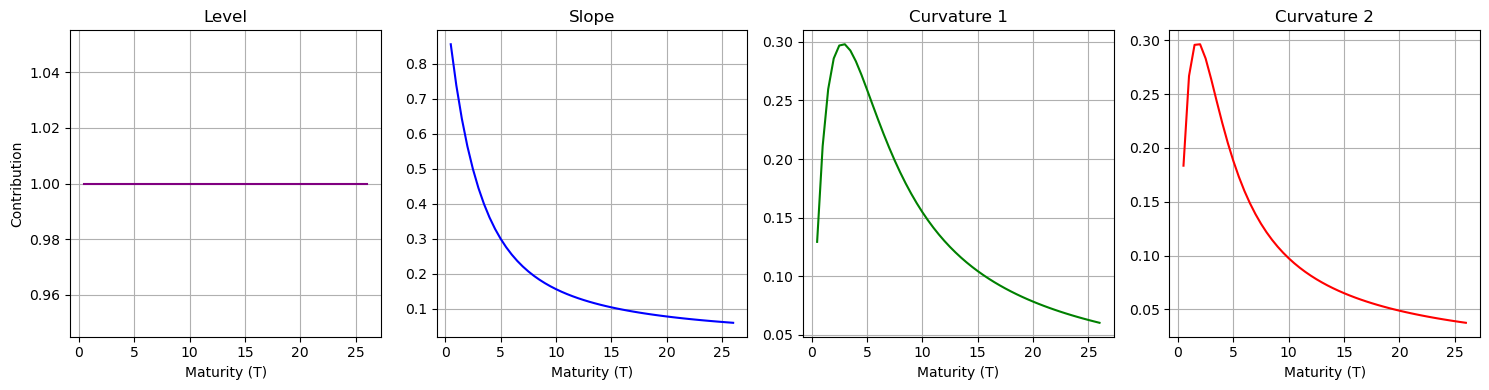

In [25]:
# Define loading functions for slope and curvature
def slope(t, t1):
    return (1 - np.exp(-t / t1)) / (t /t1)

def curvature1(t, t1, slope):
    return slope - np.exp(-t / t1)

def curvature2(t, t2):
    return ((1 - np.exp(-t / t2)) / (t / t2)) - np.exp(-t / t2)


# Calculate factor loadings based on maturity T
y_level = np.ones_like(T)  # Level factor, constant across maturities
y_slope = slope(T, t1)        # Slope factor
y_curvature1 = curvature1(T, t1, y_slope)  # First curvature factor
y_curvature2 = curvature2(T, t2)    # Second curvature factor

# Plotting each factor loading in a separate subplot
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].plot(T, y_level, label='Level Factor', color='purple')
axs[0].set_title('Level')
axs[0].set_xlabel('Maturity (T)')
axs[0].set_ylabel('Contribution')
axs[0].grid(True)

axs[1].plot(T, y_slope, label='Slope Factor', color='blue')
axs[1].set_title('Slope')
axs[1].set_xlabel('Maturity (T)')
axs[1].grid(True)

axs[2].plot(T, y_curvature1, label='Curvature Factor 1', color='green')
axs[2].set_title('Curvature 1')
axs[2].set_xlabel('Maturity (T)')
axs[2].grid(True)

axs[3].plot(T, y_curvature2, label='Curvature Factor 2', color='red')
axs[3].set_title('Curvature 2')
axs[3].set_xlabel('Maturity (T)')
axs[3].grid(True)

plt.tight_layout()
plt.show()

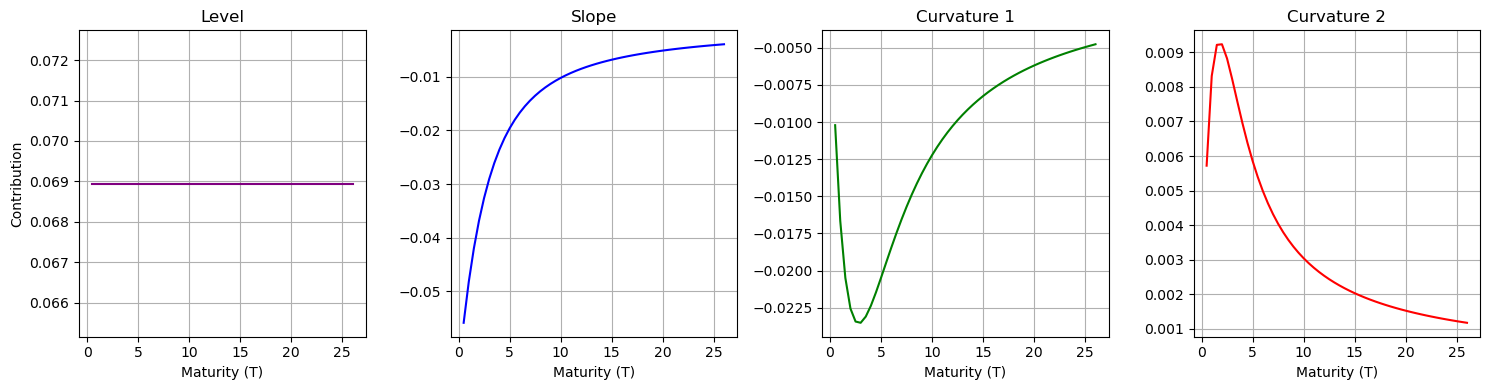

In [26]:
# Plotting each factor loading in a separate subplot
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].plot(T, b0*y_level, label='Level Factor', color='purple')
axs[0].set_title('Level')
axs[0].set_xlabel('Maturity (T)')
axs[0].set_ylabel('Contribution')
axs[0].grid(True)

axs[1].plot(T, b1*y_slope, label='Slope Factor', color='blue')
axs[1].set_title('Slope')
axs[1].set_xlabel('Maturity (T)')
axs[1].grid(True)

axs[2].plot(T, b2*y_curvature1, label='Curvature Factor 1', color='green')
axs[2].set_title('Curvature 1')
axs[2].set_xlabel('Maturity (T)')
axs[2].grid(True)

axs[3].plot(T, b3*y_curvature2, label='Curvature Factor 2', color='red')
axs[3].set_title('Curvature 2')
axs[3].set_xlabel('Maturity (T)')
axs[3].grid(True)

plt.tight_layout()
plt.show()

### Q4.1 Hedging General sensitivity over a shock


In [27]:
zc_shock = np.copy(zc)
zc_shock[np.where(T == 10)[0][0]] += 0.005

shock_spline_5 , shock_yields_5 = create_cubic_spline(T, zc_shock, knots_5)

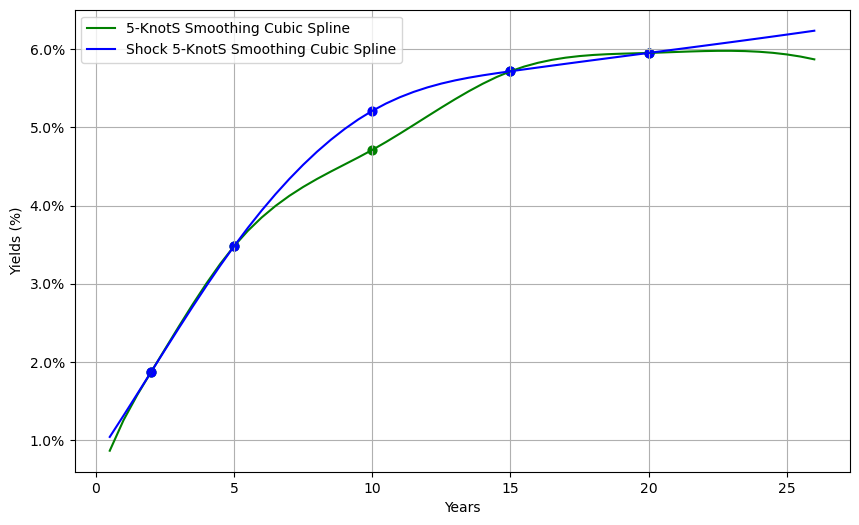

In [28]:
plt.figure(figsize=(10, 6))

plt.plot(T, smoothed_yields_5, color='green', label='5-KnotS Smoothing Cubic Spline')
plt.scatter(knots_5, smoothing_spline_5(knots_5), s=40, color='green')

plt.plot(T, shock_yields_5, color='blue', label='Shock 5-KnotS Smoothing Cubic Spline')
plt.scatter(knots_5, shock_spline_5(knots_5), s=40, color='blue')

# plt.title('Smoothed Cubic Spline Interpolation of ZC Yields')
plt.xlabel('Years')
plt.ylabel('Yields (%)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.grid()
plt.show()

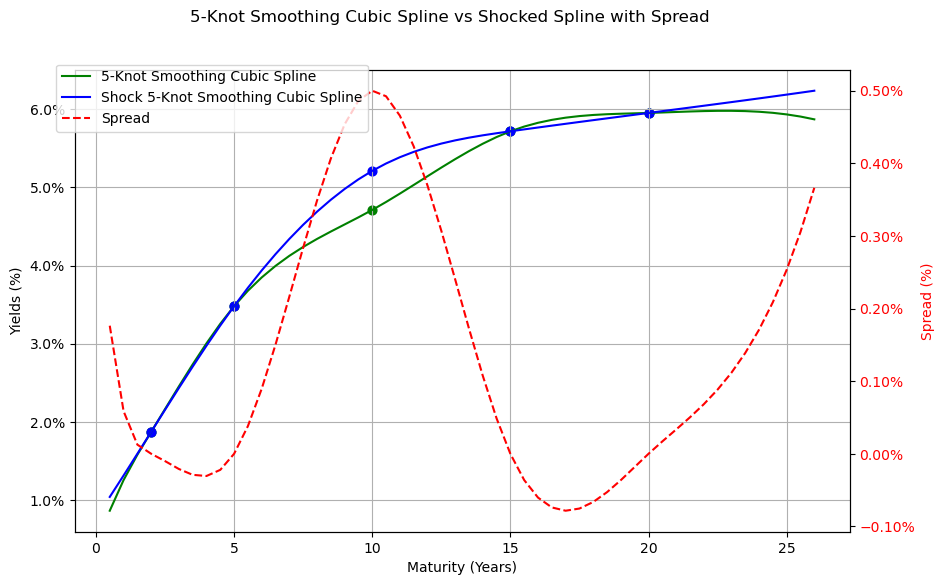

In [29]:
from matplotlib.ticker import PercentFormatter


# Plot the two yield curves
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(T, smoothed_yields_5, color='green', label='5-Knot Smoothing Cubic Spline')
ax1.scatter(knots_5, smoothing_spline_5(knots_5), s=40, color='green')

ax1.plot(T, shock_yields_5, color='blue', label='Shock 5-Knot Smoothing Cubic Spline')
ax1.scatter(knots_5, shock_spline_5(knots_5), s=40, color='blue')

# Calculate the spread and add it to a secondary y-axis
spread = smoothed_yields_5 - shock_yields_5
ax2 = ax1.twinx()
ax2.plot(T, -spread, color='red', linestyle='--', label='Spread')
ax2.set_ylabel('Spread (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.yaxis.set_major_formatter(PercentFormatter(1))

# Set labels and legend
ax1.set_xlabel('Maturity (Years)')
ax1.set_ylabel('Yields (%)')
ax1.yaxis.set_major_formatter(PercentFormatter(1))
fig.suptitle('5-Knot Smoothing Cubic Spline vs Shocked Spline with Spread')

# Add grid and legends
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
ax1.grid()
plt.show()


### Q4.2 Key Rate Duration (KRD) of Portfolio


In [30]:
# defining a new function to take into account the shock while calculating the discount factor 
# Inverse function for zero-coupon yield
def inv(current_prices, coupons, periods, face=100):
    return (((face + coupons / 2) / current_prices) ** (1 / periods) - 1) * 2

def bootstrap_shock_single(current_prices, coupons, periods, maturity, shock=0.005, face = 100):

    # first stripping
    zc = [((face + coupons[0] * 0.5) / current_prices[0] - 1) * 2]
    discount_factors = [1 / (1 + zc[0] * 0.5)]
    pos = (maturity * 2 - 1) 

    for i in range(1, len(current_prices)):
        
        cash_flow = sum(coupons[i] / 2 * discount_factors[j] for j in range(i))

        # check if the shock has to be applied 
        # if the maturity correspond, apply the shock 
        if i != pos:
            zc.append(inv(current_prices[i] - cash_flow, coupons[i], periods[i], face))
        else:
            zc.append(inv(current_prices[i] - cash_flow, coupons[i], periods[i], face) + 0.005)
            
        discount_factors.append(1 / (1 + zc[i] * 0.5) ** periods[i])
        
    return discount_factors, zc

In [31]:
discount_factors_shock, zc_shock = bootstrap_shock_single(current_prices, coupons, periods, maturity = 10)

# Create a DataFrame with Maturity, Zero-Coupon Yield (ZC), and Discount Factor (DF)
bootstrap_df_shock_ten = pd.DataFrame({
    "Maturity (Years)": T,
    "Zero-Coupon Yield (ZC)": zc_shock,
    "Discount Factor (DF)": discount_factors_shock,
    "Coupon_rate": exhibit_1['Coupon Rate (%)'],
    "Current Price":  exhibit_1['Current Price']
})

In [32]:
# merge old and new df to calculate the difference 

merged_df = bootstrap_df.merge(
    bootstrap_df_shock_ten, 
    on="Maturity (Years)", 
    suffixes=('', '_shock')
)

In [33]:
# strip old price and add new one 
def new_shocked_prices(df, par=100):
    
    new_price = np.array([])
    for i in range(0, df.shape[0]):

        #variables
        initial_price = df['Current Price'][i]
        old_discount_factor = df['Discount Factor (DF)'][i]
        coupon = df['Coupon_rate'][i]/2
        new_discount_factor = df['Discount Factor (DF)_shock'][i]

        
        # price calculation without (wo) the coupon
        price_wo = initial_price - (par + coupon) * old_discount_factor

        # Add the shock 
        price_wt = price_wo + (par + coupon) * new_discount_factor    
        new_price = np.append(new_price, price_wt)

    df_price = pd.DataFrame({
        "old_price" : df['Current Price'],
        "new_price" : new_price,
        "shock":  df['Current Price'] - new_price})
    return df_price
    


In [34]:
# create a new df with the shock 
ten_y_shock = new_shocked_prices(merged_df)

In [35]:
def duration_cal(df, initial_investment = 1000000):
    # value the impact 
    initial_investment = 1000000
    single_investment = initial_investment/df.shape[0]

    #Calculateing the KRD 
    df['number_of_bonds'] = single_investment/df['old_price']
    df['difference'] =  - df['number_of_bonds'] * df['shock']
    dollar_KRD = sum(df['difference'])
    perc_KRD = (- dollar_KRD / (initial_investment * 0.005))*100

    

    
    return dollar_KRD, perc_KRD

In [36]:
d_KRD, p_KRD = duration_cal(ten_y_shock)
print(f"The dollar duration is {round(d_KRD, 2)}$")    
print(f"The percentage duration is {round(p_KRD, 2)}%")

The dollar duration is -284.49$
The percentage duration is 5.69%


### Q4.3 KRD for All Maturities

In [37]:
# we create a function to loop over all the maturities 
def individual_shock(maturities, current_prices, coupons, periods):
    discount_factors_shock, zc_shock = bootstrap_shock_single(current_prices, coupons, periods, maturity = maturities)
    
    # Create a DataFrame with Maturity, Zero-Coupon Yield (ZC), and Discount Factor (DF)
    bootstrap_df_shock = pd.DataFrame({
        "Maturity (Years)": T,
        "Zero-Coupon Yield (ZC)": zc_shock,
        "Discount Factor (DF)": discount_factors_shock,
        "Coupon_rate": exhibit_1['Coupon Rate (%)'],
        "Current Price":  exhibit_1['Current Price']
    })

    merged_df = bootstrap_df.merge(
    bootstrap_df_shock, 
    on="Maturity (Years)", 
    suffixes=('', '_shock'))
    
    y_shock = new_shocked_prices(merged_df)
    
    return duration_cal(y_shock)

    

In [38]:
p_KRD = np.array([])

for i in T:
    percentage_duration = individual_shock(i, current_prices, coupons, periods)
    p_KRD = np.append(p_KRD, percentage_duration[1])

In [39]:
p_KRD

array([-3.28244468e-13,  5.85770659e-01,  8.92468192e-01,  9.74546597e-01,
        1.23601436e+00,  1.81789722e+00,  1.57111349e+00,  2.33624482e+00,
        2.72741572e+00,  2.99170416e+00,  2.52994479e+00,  2.58807117e+00,
        2.60846039e+00,  3.13062094e+00,  3.75537224e+00,  4.02130782e+00,
        4.36724794e+00,  5.01580748e+00,  5.74712620e+00,  5.68980070e+00,
        7.76373282e-01,  1.04090877e+00,  1.59564691e+00,  1.91805761e+00,
        2.69399241e+00,  3.93846208e+00,  3.21721395e+00,  3.25176135e+00,
        3.21070133e+00,  3.40077414e+00,  3.59354779e+00,  4.23996003e+00,
        4.10458409e+00,  4.05547641e+00,  4.83756654e+00,  4.78980502e+00,
        5.03174050e+00,  5.82239000e+00,  6.09894762e+00,  7.18719305e+00,
        6.12024297e+00,  6.25912206e+00,  6.30337404e+00,  7.17349943e+00,
        8.38037175e+00,  7.66678922e+00,  7.99919976e+00,  8.45695332e+00,
        8.93139948e+00,  9.99287857e+00,  1.05985837e+01,  9.54224219e+00])

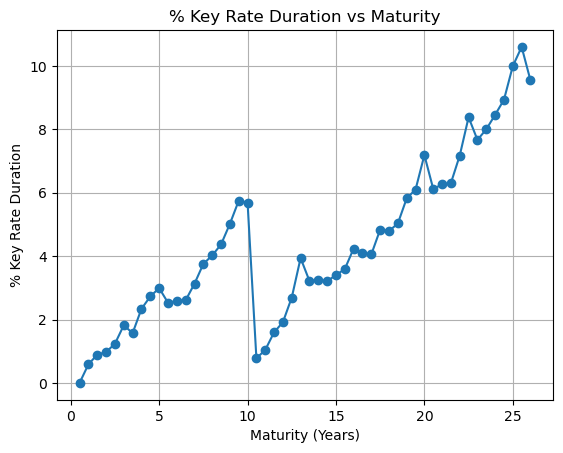

In [40]:
plt.plot(T, p_KRD, marker='o', linestyle='-')
plt.xlabel('Maturity (Years)')
plt.ylabel('% Key Rate Duration')
plt.title('% Key Rate Duration vs Maturity')
plt.grid(True)
plt.show()

### Q5.1 Portfolio Strategy Steepening Bootstrapped Curve

In [41]:
def steepen_yield_curve(maturities, yields, T_star, epsilon_std=0.0025):
    """
    yields: bootstrapped yield curve to steepen.
    T_star: avg maturity of the bonds.
    epsilon_std: std of the noise component.
    """
    T = maturities
    y_original = yields
    
    # deterministic component
    deterministic = (T - T_star) / T_star * 0.0050
    
    # stochastic component
    np.random.seed(13)
    epsilon = np.random.normal(0, epsilon_std, len(T))
    
    # new yield curves
    y_new_deterministic = y_original + deterministic
    y_new_full = y_new_deterministic + epsilon 
    
    return epsilon*100, y_new_deterministic*100, y_new_full * 100  # return in percentage

In [42]:
# average bond maturity in our sample
T_star = np.mean(mat_model)

In [43]:
# call the function defined above
epsilon, new_yield_deterministic, new_yield_full = steepen_yield_curve(mat_model, np.array(zc_market), T_star)

In [44]:
# Create two new columns
df_results['Noise'] = np.nan
df_results['New Yield (Deterministic) (%)'] = np.nan
df_results['New Yield (Full) (%)'] = np.nan

# Update the df with the new yields for matching maturities
df_results.loc[df_results['Maturity (Years)'].isin(mat_model), 'Noise'] = epsilon
df_results.loc[df_results['Maturity (Years)'].isin(mat_model), 'New Yield (Deterministic) (%)'] = new_yield_deterministic
df_results.loc[df_results['Maturity (Years)'].isin(mat_model), 'New Yield (Full) (%)'] = new_yield_full

# Print the results side by side
print("New Yield Curves After Steepening:")
print(df_results[['Maturity (Years)', 
                 'Selected ZC Yields', 
                 'New Yield (Deterministic) (%)', 
                 'Noise', 
                 'New Yield (Full) (%)']].to_string(index=False))

New Yield Curves After Steepening:
 Maturity (Years)  Selected ZC Yields  New Yield (Deterministic) (%)     Noise  New Yield (Full) (%)
              1.0            0.011930                       0.749484 -0.178098              0.571386
              2.0            0.018727                       1.485761  0.188442              1.674203
              3.0            0.024711                       2.140677 -0.011126              2.129551
              4.0            0.030084                       2.734465  0.112953              2.847418
              5.0            0.034799                       3.262522  0.336275              3.598798
              6.0            0.038817                       3.720841  0.133084              3.853926
              7.0            0.042203                       4.115988  0.337547              4.453535
              8.0            0.044865                       4.438704  0.215303              4.654007
              9.0            0.046640                   

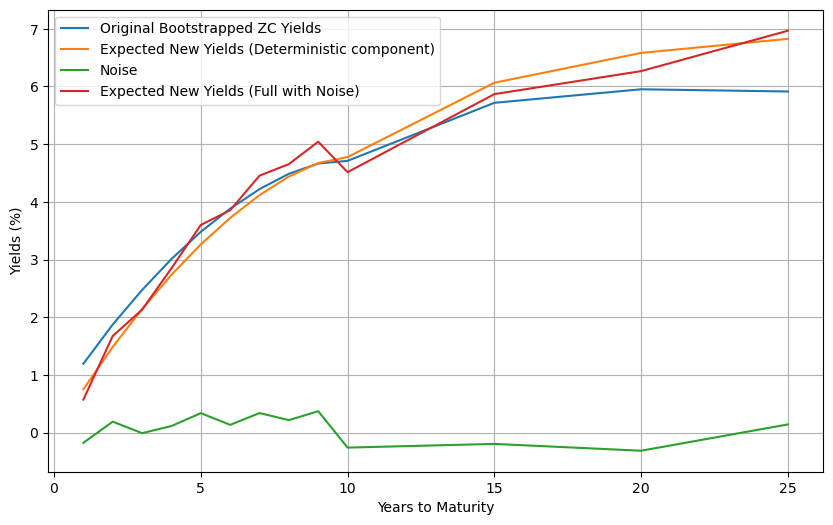

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(mat_model, 
         df_results['Selected ZC Yields']*100, 
         label="Original Bootstrapped ZC Yields")
plt.plot(mat_model, 
         df_results['New Yield (Deterministic) (%)'], 
         label="Expected New Yields (Deterministic component)")
plt.plot(mat_model, 
         df_results['Noise'], 
         label="Noise")
plt.plot(mat_model, 
         df_results['New Yield (Full) (%)'], 
         label="Expected New Yields (Full with Noise)")
#plt.title("Yield Curve Steepening")
plt.xlabel("Years to Maturity")
plt.ylabel("Yields (%)")
plt.legend()
plt.grid()
plt.show()

### Q5.2 Re-estimating Discount Function with NSS

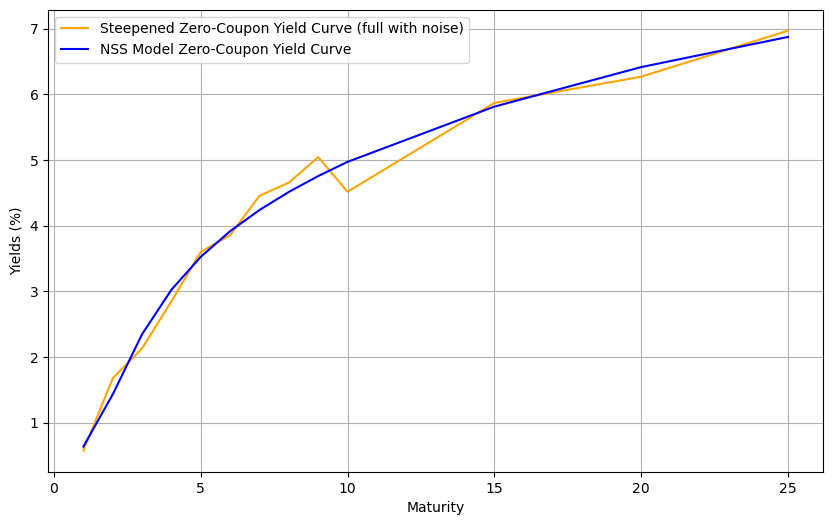

In [46]:
# Initial parameter guesses
b0, b1, b2, b3,t1, t2 = 0.1, 0.1, -1, -1, 1, 1

# Optimise NSS parameters
opt_params = fit_nss(b0, b1, b2, b3,t1, t2, mat_model, new_yield_full)

# Calculate NSS yields with optimized parameters
nss_yields = nss_curve(mat_model, *opt_params)

# Load optimised parameters for each factor
b0, b1, b2, b3, t1, t2 = opt_params

# Plot NSS model vs market data
plt.figure(figsize=(10, 6))
plt.plot(mat_model, new_yield_full, label='Steepened Zero-Coupon Yield Curve (full with noise)', color='orange')
plt.plot(mat_model, nss_yields, label='NSS Model Zero-Coupon Yield Curve', color='blue')
plt.xlabel('Maturity')
plt.ylabel('Yields (%)')
# plt.title('Steepened Zero-Coupon Yields vs. NSS Model')
plt.legend()
plt.grid()
plt.show()


In [47]:
face_value = 100  # Face value of the zero-coupon bond

# Initialize lists to store the bootstrapped prices for each maturity
bootstrapped_prices_nss = []
bootstrapped_prices_mkt = []

# Calculate zero-coupon bond prices based on NSS yields
for i, maturity in enumerate(mat_model):
    nss_yield = nss_yields[i] / 100  # Convert NSS yield to decimal

    # Price calculation for zero-coupon bond
    price = face_value / (1 + nss_yield) ** maturity
    bootstrapped_prices_nss.append(price)

# Calculate zero-coupon bond prices based on market yields
for i, maturity in enumerate(mat_model):
    market_yield = new_yield_full[i] / 100  # Convert market yield to decimal

    # Price calculation for zero-coupon bond
    price = face_value / (1 + market_yield) ** maturity
    bootstrapped_prices_mkt.append(price)


In [48]:

# Original maturities and yield arrays
mat_original = np.array(mat_model)  # Original maturity points from `mat_model`
new_yield_full_original = np.array(new_yield_full)
nss_yields_original = np.array(nss_yields)

# New maturities range (0.5 to 26 years)
mat_interp = np.arange(0.5, 26.5, 0.5) 

# Interpolate `new_yield_full` and `nss_yields`
interp_new_yield_full = interp1d(mat_original, new_yield_full_original, kind='linear', fill_value="extrapolate")
interp_nss_yields = interp1d(mat_original, nss_yields_original, kind='linear', fill_value="extrapolate")

# Create new arrays with interpolated values
new_yield_full_interp = interp_new_yield_full(mat_interp)
nss_yields_interp = interp_nss_yields(mat_interp)


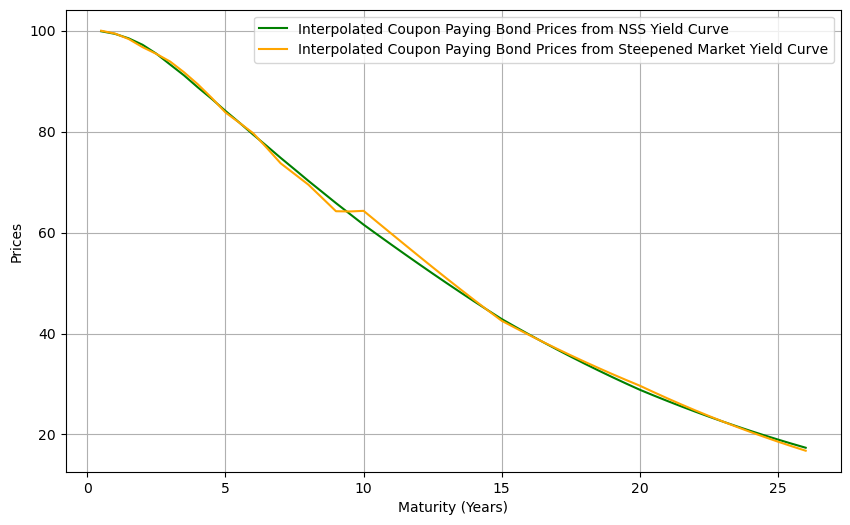

In [49]:
face_value = 100  # Face value of the zero-coupon bond

# Initialize lists to store the bootstrapped prices for each maturity
bootstrapped_prices_nss = []
bootstrapped_prices_mkt = []

# Calculate zero-coupon bond prices based on NSS yields
for i, maturity in enumerate(mat_interp):  # Use mat_interp here
    nss_yield = nss_yields_interp[i] / 100  # Convert NSS yield to decimal

    # Price calculation for zero-coupon bond
    price = face_value / (1 + nss_yield) ** maturity
    bootstrapped_prices_nss.append(price)

# Calculate zero-coupon bond prices based on market yields
for i, maturity in enumerate(mat_interp):  # Use mat_interp here
    market_yield = new_yield_full_interp[i] / 100  # Convert market yield to decimal

    # Price calculation for zero-coupon bond
    price = face_value / (1 + market_yield) ** maturity
    bootstrapped_prices_mkt.append(price)

# Plot the bootstrapped prices
plt.figure(figsize=(10, 6))
plt.plot(mat_interp, bootstrapped_prices_nss, label='Interpolated Coupon Paying Bond Prices from NSS Yield Curve', color='green')
plt.plot(mat_interp, bootstrapped_prices_mkt, label='Interpolated Coupon Paying Bond Prices from Steepened Market Yield Curve', color='orange')
plt.xlabel('Maturity (Years)')
plt.ylabel('Prices')
# plt.title('Bootstrapped Prices of Zero-Coupon Bonds Using NSS and Market Yields')
plt.legend()
plt.grid()
plt.show()

In [50]:
new_yield_full_interp *= 0.01

In [51]:
nss_yields_interp *= 0.01

In [52]:


CP_bonds = pd.DataFrame({
    'cp_rate':exhibit_1['Coupon Rate (%)'],
    'periods':T*2,
    'mkt_y': new_yield_full_interp,
    'nss_y': nss_yields_interp
})


market_price = []
snn_price = [] 

for i in range(0,len(CP_bonds)): 
    bond_price = 100 / (1+(CP_bonds.mkt_y[i]/2)) ** CP_bonds.periods[i]

    
    for j in range(0,i+1):
        bond_price += (CP_bonds.cp_rate[i]/2 /(  (1+(CP_bonds.mkt_y[j]/2)) ** CP_bonds.periods[j]))
        
    market_price.append(bond_price)
    
CP_bonds['mkt_p'] = market_price

for i in range(0,len(CP_bonds)): 
    bond_price = 100 / (1+(CP_bonds.nss_y[i]/2)) ** CP_bonds.periods[i]
    
    for j in range(0,i+1):
        bond_price += (CP_bonds.cp_rate[i]/2 /(  (1+(CP_bonds.nss_y[j]/2)) ** CP_bonds.periods[j]))
        
    snn_price.append(bond_price)

CP_bonds['snn_p'] = snn_price


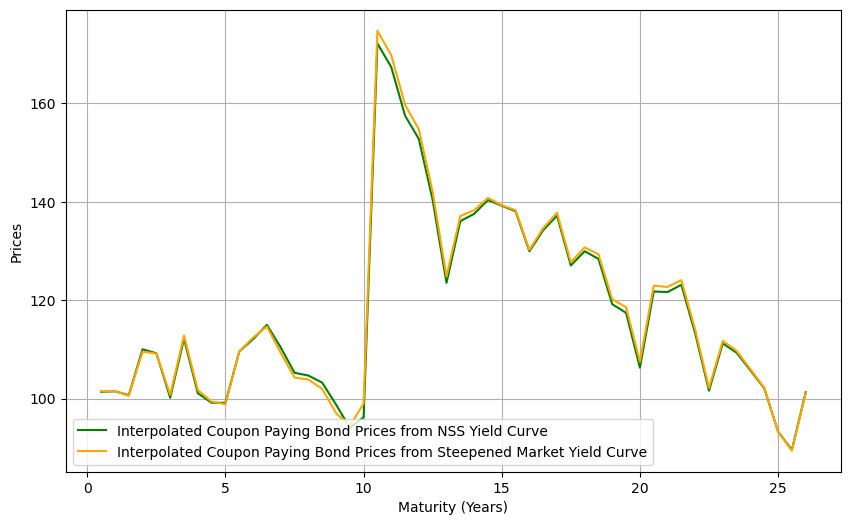

In [53]:
# Plot the bootstrapped prices
plt.figure(figsize=(10, 6))
plt.plot(mat_interp, snn_price, label='Interpolated Coupon Paying Bond Prices from NSS Yield Curve', color='green')
plt.plot(mat_interp, market_price, label='Interpolated Coupon Paying Bond Prices from Steepened Market Yield Curve', color='orange')
plt.xlabel('Maturity (Years)')
plt.ylabel('Prices')
# plt.title('Bootstrapped Prices of Zero-Coupon Bonds Using NSS and Market Yields')
plt.legend()
plt.grid()
plt.show()

In [54]:
cheap_bonds = []
expensive_bonds = []

for i in range(0,len(CP_bonds)):
    
    if CP_bonds.mkt_p[i] < CP_bonds.snn_p[i]:
        cheap_bonds.append([CP_bonds.periods[i]/2, CP_bonds.mkt_p[i], CP_bonds.snn_p[i]])
        
for i in range(0,len(CP_bonds)):
    
    if CP_bonds.mkt_p[i] > CP_bonds.snn_p[i]:
        expensive_bonds.append([CP_bonds.periods[i]/2, CP_bonds.mkt_p[i], CP_bonds.snn_p[i]])

In [55]:
print("Cheap Bonds (Market Price < NSS Price):")
for i in range(0,len(cheap_bonds)):
    print(f"Maturity {cheap_bonds[i][0]} years: Market Price {cheap_bonds[i][1]:.2f}, NSS Price {cheap_bonds[i][2]:.2f}")

print("\nExpensive Bonds (Market Price > NSS Price):")
for i in range(0,len(expensive_bonds)):
    print(f"Maturity {expensive_bonds[i][0]} years: Market Price {expensive_bonds[i][1]:.2f}, NSS Price {expensive_bonds[i][2]:.2f}")


Cheap Bonds (Market Price < NSS Price):
Maturity 1.5 years: Market Price 100.57, NSS Price 100.70
Maturity 2.0 years: Market Price 109.54, NSS Price 110.03
Maturity 2.5 years: Market Price 109.16, NSS Price 109.20
Maturity 5.0 years: Market Price 98.86, NSS Price 99.15
Maturity 6.5 years: Market Price 114.66, NSS Price 115.00
Maturity 7.0 years: Market Price 109.29, NSS Price 110.39
Maturity 7.5 years: Market Price 104.28, NSS Price 105.24
Maturity 8.0 years: Market Price 103.88, NSS Price 104.69
Maturity 8.5 years: Market Price 101.98, NSS Price 103.25
Maturity 9.0 years: Market Price 97.07, NSS Price 98.80
Maturity 25.0 years: Market Price 93.28, NSS Price 93.32
Maturity 25.5 years: Market Price 89.40, NSS Price 89.56
Maturity 26.0 years: Market Price 101.07, NSS Price 101.28

Expensive Bonds (Market Price > NSS Price):
Maturity 0.5 years: Market Price 101.49, NSS Price 101.38
Maturity 1.0 years: Market Price 101.55, NSS Price 101.49
Maturity 3.0 years: Market Price 100.77, NSS Price

### Q5.3 Zero-Cost Long-Short Portfolio Strategy

### Portfolio using steepened version of the initial boostrapped ZC curve and NSS  fitted curve 

In [56]:
long_positions = np.array(cheap_bonds)
short_positions = np.array(expensive_bonds)

long_mispricing = (- long_positions[:, 1] + long_positions[:, 2])/  long_positions[:, 1]
short_mispricing = (short_positions[:, 1] - short_positions[:, 2])/short_positions[:, 1]  

In [57]:
# normalize weights 
long_weights = long_mispricing / long_mispricing.sum() 
short_weights = short_mispricing / short_mispricing.sum()

In [58]:
# return calculation 
long_ret = (((- long_positions[:, 1] + long_positions[:, 2])/long_positions[:, 1]) * long_weights).sum()
short_ret = (((short_positions[:, 1] - short_positions[:, 2])/short_positions[:, 1]) * short_weights).sum()

In [59]:
total_investment = 100

long_allocations = long_weights * total_investment 
short_allocations = short_weights * total_investment

# filter maturities 
long_maturities = long_positions[:, 0] 
short_maturities = short_positions[:, 0]

In [60]:
long_expected_return = (long_allocations * long_mispricing).sum() 
short_expected_return = (short_allocations * short_mispricing).sum()

total_expected_return = long_expected_return + short_expected_return

In [61]:
print("Long Allocations (Undervalued Bonds):")
for maturity, allocation in zip(long_maturities, long_allocations):
    print(f"Maturity {maturity} years: ${allocation:.2f}")

print("\nShort Allocations (Overvalued Bonds):")
for maturity, allocation in zip(short_maturities, short_allocations):
    print(f"Maturity {maturity} years: ${allocation:.2f}")
    
print(f"\nTotal Expected Return of Zero-Cost Portfolio: {total_expected_return:.2f}%")

Long Allocations (Undervalued Bonds):
Maturity 1.5 years: $1.80
Maturity 2.0 years: $6.00
Maturity 2.5 years: $0.59
Maturity 5.0 years: $3.93
Maturity 6.5 years: $4.04
Maturity 7.0 years: $13.58
Maturity 7.5 years: $12.54
Maturity 8.0 years: $10.60
Maturity 8.5 years: $16.85
Maturity 9.0 years: $24.24
Maturity 25.0 years: $0.58
Maturity 25.5 years: $2.45
Maturity 26.0 years: $2.78

Short Allocations (Overvalued Bonds):
Maturity 0.5 years: $0.42
Maturity 1.0 years: $0.24
Maturity 3.0 years: $2.30
Maturity 3.5 years: $2.20
Maturity 4.0 years: $2.43
Maturity 4.5 years: $0.84
Maturity 5.5 years: $0.01
Maturity 6.0 years: $1.14
Maturity 9.5 years: $1.69
Maturity 10.0 years: $10.76
Maturity 10.5 years: $5.72
Maturity 11.0 years: $5.52
Maturity 11.5 years: $5.33
Maturity 12.0 years: $4.88
Maturity 12.5 years: $4.47
Maturity 13.0 years: $3.97
Maturity 13.5 years: $2.93
Maturity 14.0 years: $2.05
Maturity 14.5 years: $1.17
Maturity 15.0 years: $0.25
Maturity 15.5 years: $0.55
Maturity 16.0 year